# Sodium Voltage-gated Channel, Alpha Subunit 2 (SCN2A) and Associated Syndrome

[Sodium Voltage-gated Channel, Alpha Subunit 2 (SCN2A)](https://www.omim.org/entry/182390) is a gene that encodes the voltage-gated sodium channel Na(v)1.2. This effects the initiation and conduction of action potentials in unmyelinated axons. 

There are three known syndromes associated with pathogenic variants on SCN2A, two of which are included in this analysis. 

[Developmental and epileptic encephalopathy 11](https://www.omim.org/entry/613721) is an autosomal dominant disease, with onset in infancy. It is characterized by seizures, developmental delay, status epilepticus, abnormal movements, autistic features, and many other neurological phenotypes, microcephaly, and oculogyric crises. The severity of this disease varies significantly among individuals. 

[Seizures, benign familial infantile, 3](https://www.omim.org/entry/607745) is an autosomal dominant disease, with onset within 7 months of birth. It is characterized by seizures, apnea during seizures, staring episodes during seizures, and cyanosis. 

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

Several previous publications have reported candidate genotype-phenotype correlations for variants on SCN2A.

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Reynolds et al. (2020)](https://www.sciencedirect.com/science/article/pii/S1090379819304362) stated that:

> "There are two recurrent variants identified in this cohort [individuals with neonatal seizures and later onset episodic ataxia], p.Ala263Val and p.Arg1882Gly."

> "Missense variants in SCN2A, causing a GOF are identified in cohorts with BFNIS (Benign familial neonatal-infantile seizures) and DEE (Developmental and epileptic encephalopathies) onset <3 months."

[Wolff et al. (2020)](https://onlinelibrary.wiley.com/doi/full/10.1111/epi.14935) stated that:

> "The R853Q (S4 domain 2) variant was found in patients often presenting with West syndrome, severe intellectual disability, intractable seizures, and choreoathetosis."

> "SCN2A variants in the subgroup of ID/ASD are mainly truncating (75%), with missense variants occurring in 25%."


Therefore, we tested missense vs other variants, p.Arg853Gln vs all others, those in domain 2 vs anywhere else, and p.Ala263Val & p.Arg1882Gly vs all others. 

# Imports 

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release="v2025-01-16")
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.6.dev0


### SCN2A
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SCN2A.

In [3]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SCN2A'
mane_tx_id = 'NM_021007.3'
mane_protein_id = 'NP_066287.2'
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [4]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.24'
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 393/393 [00:00<00:00, 1332.53 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
127,Epileptic encephalopathy
97,"Intellectual disability, severe"
92,Autism
86,Bilateral tonic-clonic seizure
84,Global developmental delay
74,Multifocal epileptiform discharges
74,Seizure
72,Generalized tonic seizure
69,Hypotonia
64,Infantile spasms


## Protein sequence effects

Summarize effects on the protein sequence

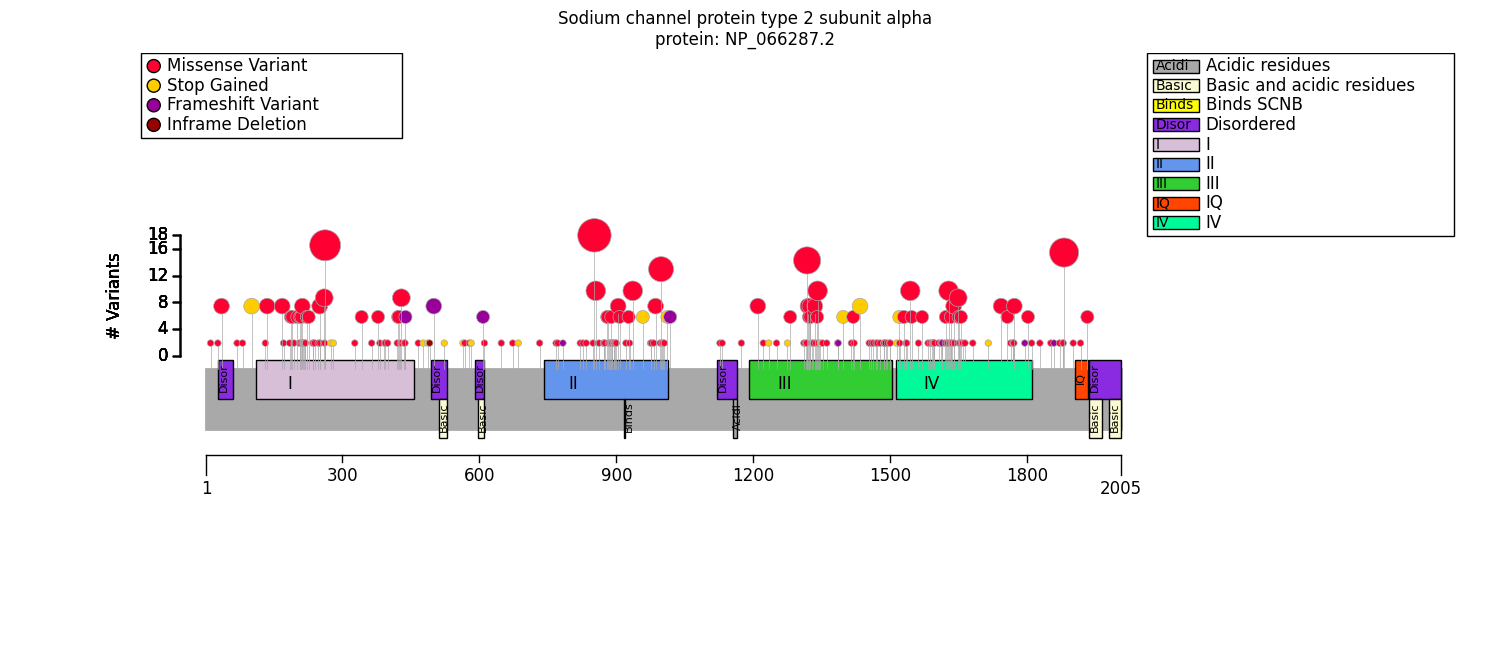

In [6]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

scn2a_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
scn2a_fig.tight_layout()

In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
18,2_165342465_165342465_G_A,c.2558G>A (p.Arg853Gln),15,missense
14,2_165310413_165310413_C_T,c.788C>T (p.Ala263Val),7,missense
10,2_165389451_165389451_G_A,c.5645G>A (p.Arg1882Gln),27,missense
8,2_165354267_165354267_G_A,c.2995G>A (p.Glu999Lys),17,missense
5,2_165374737_165374737_T_C,c.4025T>C (p.Leu1342Pro),22,missense
5,2_165373331_165373331_G_A,c.3956G>A (p.Arg1319Gln),21,missense
4,2_165386827_165386827_A_G,c.4633A>G (p.Met1545Val),26,missense
4,2_165310406_165310406_G_A,c.781G>A (p.Val261Met),7,missense
4,2_165388755_165388755_T_C,c.4949T>C (p.Leu1650Pro),27,missense
4,2_165388692_165388692_G_A,c.4886G>A (p.Arg1629His),27,missense


In [8]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,29 - 61,p.Arg36Gly
87,I,Repeat,112 - 456,p.Asn212Asp; p.Trp191Gly; p.Phe262Ser; p.Phe328Val; p.Thr218Lys; p.Met136Ile; p.Glu440ArgfsTer20; p.Ala240Ser; p.Thr227Ile; p.Arg379His; p.Thr400Arg; p.Ala263Val; p.Asp343Gly; p.Val213Ala; p.Arg275Ter; p.Leu216Trp; p.Val424Leu; p.Glu430Gly; p.Ala439Ter; p.Ala202Val; p.Glu438Asp; p.Leu248Pro; p.Glu430Ala; p.Val261Met; p.Glu430Gln; p.Thr365Met; p.Ser214Pro; p.Phe207Ser; p.Glu169Ter; p.Asp195Gly; p.Trp281Ter; p.Ala263Thr; p.Thr185Ile; p.Arg395Pro; p.Met252Val; p.Arg223Gln; p.Arg220Gly; p.Leu421Val; p.Thr236Ser; p.Gly211Asp; p.Val251Ala; p.Val423Leu; p.Val208Glu; p.Ile237Asn; p.Asn132Lys; p.Ile172Val; p.Gln383Glu; p.Val213Asp; p.Trp191Cys; p.Val251Ile; p.Val424Met; p.Tyr428Cys; p.Leu436Ser; p.Glu169Gly; p.Thr393Lys; p.Arg188Trp
4,Disordered,Region,495 - 529,p.Leu501Ter; p.Arg524Ter; p.Asn503LysfsTer19
1,Basic and acidic residues,Compositional bias,512 - 529,p.Arg524Ter
2,Disordered,Region,591 - 610,p.Asp609Ter; p.Leu611ValfsTer35
2,Basic and acidic residues,Compositional bias,597 - 610,p.Asp609Ter; p.Leu611ValfsTer35
85,II,Repeat,742 - 1013,p.Phe895Ser; p.Asp997Tyr; p.Phe978Leu; p.Arg856Gln; p.Arg937Cys; p.Arg856Ter; p.Asn976Lys; p.Ile769Thr; p.Leu835Phe; p.Leu1003Ile; p.Phe928Cys; p.Arg850Pro; p.Gly828Val; p.Gly882Arg; p.Gly899Ser; p.His930Gln; p.Cys959Ter; p.Leu983Trp; p.Gln901Glu; p.Gly822Ser; p.Gly882Glu; p.Ile874MetfsTer5; p.Thr773Ile; p.Glu999Val; p.Val887Ala; p.Lys905Asn; p.Asn876Thr; p.Arg922Cys; p.Ile890Met; p.Leu881Pro; p.Thr784CysfsTer45; p.Arg937His; p.Lys908Glu; p.Ser863Phe; p.Gly1013Ter; p.Arg853Gln; p.Ser987Ile; p.Ile873Met; p.Val892Ile; p.Ile891Thr; p.Asn1001Lys; p.Leu884His; p.Ala896Val; p.Glu999Lys; p.Arg856Leu; p.Lys905Gln; p.Ala1006Val
0,Binds SCN2B,Region,918 - 918,
2,Disordered,Region,1121 - 1165,p.Glu1133Asp; p.Met1128Thr
0,Acidic residues,Compositional bias,1156 - 1165,


# Genotype-Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect 
from gpsea.analysis.clf import monoallelic_classifier 
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
"Skipping ""general"" level terms",97
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),469


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Motor seizure [HP:0020219],146/175 (83%),6/31 (19%),7.217566e-11,4.510979e-12
Focal-onset seizure [HP:0007359],141/170 (83%),8/33 (24%),6.926826e-10,8.658533e-11
Seizure [HP:0001250],298/327 (91%),28/53 (53%),8.381259e-10,1.571486e-10
Generalized-onset seizure [HP:0002197],104/133 (78%),6/31 (19%),5.724242e-09,1.431061e-09
Autism [HP:0000717],59/146 (40%),33/43 (77%),8.612158e-05,2.691299e-05
Intellectual disability [HP:0001249],144/198 (73%),34/34 (100%),2.503177e-04,9.386915e-05
Neurodevelopmental abnormality [HP:0012759],201/238 (84%),45/45 (100%),3.193535e-03,1.397172e-03
Interictal epileptiform activity [HP:0011182],172/200 (86%),12/17 (71%),2.499082e-01,1.484832e-01
Interictal EEG abnormality [HP:0025373],172/199 (86%),13/18 (72%),2.499082e-01,1.544847e-01
EEG abnormality [HP:0002353],183/210 (87%),14/19 (74%),2.499082e-01,1.561926e-01


In [12]:
from gpsea.analysis.predicate import protein_feature

i_repeat = protein_feature(feature_id="I", protein_metadata=protein_meta)

i_clf = monoallelic_classifier(
    a_predicate=i_repeat,
    b_predicate=~i_repeat,
    a_label="I repeat",
    b_label="Other"
)

i_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=i_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=i_result)

Allele group,I repeat,Other,Corrected p values,p values
Intellectual disability [HP:0001249],21/42 (50%),157/190 (83%),0.000415,0.000026
Neurodevelopmental abnormality [HP:0012759],48/65 (74%),198/218 (91%),0.009480,0.001185
Focal-onset seizure [HP:0007359],39/46 (85%),110/157 (70%),0.223422,0.057492
Motor seizure [HP:0020219],39/46 (85%),113/160 (71%),0.223422,0.058945
Seizure [HP:0001250],79/86 (92%),247/294 (84%),0.223422,0.078884
Autism [HP:0000717],11/32 (34%),81/157 (52%),0.223422,0.083783
Generalized-onset seizure [HP:0002197],27/34 (79%),83/130 (64%),0.234709,0.102685
Aplasia/Hypoplasia of the cerebrum [HP:0007364],11/38 (29%),46/128 (36%),0.992394,0.559814
EEG abnormality [HP:0002353],48/57 (84%),149/172 (87%),0.992394,0.661958
Interictal EEG abnormality [HP:0025373],47/56 (84%),138/161 (86%),0.992394,0.827052


In [13]:
from gpsea.analysis.predicate import variant_key

arg853gln = variant_key("2_165342465_165342465_G_A")  # c.2558G>A	p.Arg853Gln
arg853gln_clf = monoallelic_classifier(
    a_predicate=arg853gln,
    b_predicate=~arg853gln,
    a_label="Arg853Gln",
    b_label="Other"
)
arg853gln_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg853gln_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=arg853gln_result)

Allele group,Arg853Gln,Other,Corrected p values,p values
Generalized-onset seizure [HP:0002197],9/9 (100%),101/155 (65%),0.235813,0.030795
Motor seizure [HP:0020219],12/12 (100%),140/194 (72%),0.235813,0.038768
Intellectual disability [HP:0001249],14/14 (100%),164/218 (75%),0.235813,0.044215
Abnormal muscle tone [HP:0003808],7/7 (100%),107/156 (69%),0.309446,0.103527
Aplasia/Hypoplasia of the cerebrum [HP:0007364],7/12 (58%),50/154 (32%),0.309446,0.110542
Seizure [HP:0001250],17/17 (100%),309/363 (85%),0.309446,0.146802
Abnormal cerebral morphology [HP:0002060],9/14 (64%),82/186 (44%),0.309446,0.170426
Abnormal forebrain morphology [HP:0100547],9/14 (64%),82/186 (44%),0.309446,0.170426
Interictal epileptiform activity [HP:0011182],12/12 (100%),172/205 (84%),0.309446,0.220643
Interictal EEG abnormality [HP:0025373],12/12 (100%),173/205 (84%),0.309446,0.221401


In [14]:
from gpsea.analysis.predicate import exon

# Exon 27 is commonly mutated
ex27 = exon(exon=27, tx_id=mane_tx_id)
ex27_predicate = monoallelic_classifier(
    a_predicate=ex27,
    b_predicate=~ex27,
    a_label="Exon 27",
    b_label="Other"
)
ex27_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ex27_predicate,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=ex27_result)

Allele group,Exon 27,Other,Corrected p values,p values
Interictal epileptiform activity [HP:0011182],33/46 (72%),151/171 (88%),0.069289,0.009769
EEG abnormality [HP:0002353],33/45 (73%),164/184 (89%),0.069289,0.014071
Neurodevelopmental abnormality [HP:0012759],57/59 (97%),189/224 (84%),0.069289,0.015078
Interictal EEG abnormality [HP:0025373],33/45 (73%),152/172 (88%),0.069289,0.017322
Intellectual disability [HP:0001249],44/50 (88%),134/182 (74%),0.119917,0.037474
Abnormal muscle tone [HP:0003808],31/40 (78%),83/123 (67%),0.855555,0.320833
Aplasia/Hypoplasia of the cerebrum [HP:0007364],15/38 (39%),42/128 (33%),1.000000,0.444523
Generalized-onset seizure [HP:0002197],23/33 (70%),87/131 (66%),1.000000,0.836813
Focal-onset seizure [HP:0007359],26/36 (72%),123/167 (74%),1.000000,0.837907
Autism [HP:0000717],18/36 (50%),74/153 (48%),1.000000,1.000000


# Summary

In [15]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=i_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=arg853gln_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=ex27_result
    )
)

caption = "."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [16]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,Missense,Other,p-val,adj. p-val
Neurodevelopmental abnormality [HP:0012759],201/238 (84%),45/45 (100%),0.001,0.003
Motor seizure [HP:0020219],146/175 (83%),6/31 (19%),4.51e-12,7.22e-11
Seizure [HP:0001250],298/327 (91%),28/53 (53%),1.57e-10,8.38e-10
Autism [HP:0000717],59/146 (40%),33/43 (77%),2.69e-05,8.61e-05
Focal-onset seizure [HP:0007359],141/170 (83%),8/33 (24%),8.66e-11,6.93e-10
Generalized-onset seizure [HP:0002197],104/133 (78%),6/31 (19%),1.43e-09,5.72e-09
Intellectual disability [HP:0001249],144/198 (73%),34/34 (100%),9.39e-05,2.50e-04
HPO Term,I repeat,Other,p-val,adj. p-val
Neurodevelopmental abnormality [HP:0012759],48/65 (74%),198/218 (91%),0.001,0.009
Intellectual disability [HP:0001249],21/42 (50%),157/190 (83%),2.59e-05,4.15e-04


In [17]:
summarizer.process_latex(report=report, protein_fig=scn2a_fig)

Figure saved to ../../supplement/img/SCN2A_protein_diagram-draft.pdf
Output to ../../supplement/tex/SCN2A_summary_draft.tex
